In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Download and Data preprocessing

In [2]:
!curl -LJ "https://raw.githubusercontent.com/ningshixian/NER-CONLL2003/master/data/train.txt" -o "train.txt"
!curl -LJ "https://raw.githubusercontent.com/ningshixian/NER-CONLL2003/master/data/valid.txt" -o "valid.txt"
!curl -LJ "https://raw.githubusercontent.com/ningshixian/NER-CONLL2003/master/data/test.txt" -o "test.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3206k  100 3206k    0     0  7917k      0 --:--:-- --:--:-- --:--:-- 7917k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  808k  100  808k    0     0   995k      0 --:--:-- --:--:-- --:--:--  993k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  730k  100  730k    0     0  2476k      0 --:--:-- --:--:-- --:--:-- 2476k


In [3]:
!head -5 train.txt

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC


In [4]:
import nltk
from nltk.corpus.reader import ConllCorpusReader

In [5]:
train_sentences = ConllCorpusReader("./", "train.txt", ["words", "pos", "ignore", "chunk"]).iob_sents()
valid_sentences = ConllCorpusReader("./", "valid.txt", ["words", "pos", "ignore", "chunk"]).iob_sents()
test_sentences = ConllCorpusReader("./", "test.txt", ["words", "pos", "ignore", "chunk"]).iob_sents()

Remove empty (len = 0) sentences due to data error.

In [6]:
train_sentences = [s for s in train_sentences if len(s) > 0]
valid_sentences = [s for s in valid_sentences if len(s) > 0]
test_sentences = [s for s in test_sentences if len(s) > 0]

In [7]:
print(f"Length of train set: {len(train_sentences)}")
print(f"Length of validation set: {len(valid_sentences)}")
print(f"Length of test set: {len(test_sentences)}")

Length of train set: 14041
Length of validation set: 3250
Length of test set: 3453


In [8]:
train_sentences[0]

[('EU', 'NNP', 'B-ORG'),
 ('rejects', 'VBZ', 'O'),
 ('German', 'JJ', 'B-MISC'),
 ('call', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('boycott', 'VB', 'O'),
 ('British', 'JJ', 'B-MISC'),
 ('lamb', 'NN', 'O'),
 ('.', '.', 'O')]

In [9]:
valid_sentences[0]

[('CRICKET', 'NNP', 'O'),
 ('-', ':', 'O'),
 ('LEICESTERSHIRE', 'NNP', 'B-ORG'),
 ('TAKE', 'NNP', 'O'),
 ('OVER', 'IN', 'O'),
 ('AT', 'NNP', 'O'),
 ('TOP', 'NNP', 'O'),
 ('AFTER', 'NNP', 'O'),
 ('INNINGS', 'NNP', 'O'),
 ('VICTORY', 'NN', 'O'),
 ('.', '.', 'O')]

In [10]:
test_sentences[0]

[('SOCCER', 'NN', 'O'),
 ('-', ':', 'O'),
 ('JAPAN', 'NNP', 'B-LOC'),
 ('GET', 'VB', 'O'),
 ('LUCKY', 'NNP', 'O'),
 ('WIN', 'NNP', 'O'),
 (',', ',', 'O'),
 ('CHINA', 'NNP', 'B-PER'),
 ('IN', 'IN', 'O'),
 ('SURPRISE', 'DT', 'O'),
 ('DEFEAT', 'NN', 'O'),
 ('.', '.', 'O')]

Format the data to (token, chunk)

In [11]:
def create_data(dataset):
    data = []
    label = []
    for sentence in dataset:
        current_data = []
        current_label = []
        
        for token, _, chunk in sentence:
            current_data.append(token.lower())
            current_label.append(chunk)
        
        data.append(current_data)
        label.append(current_label)

    return data, label

In [12]:
train_data, train_labels = create_data(train_sentences)
val_data, val_labels = create_data(valid_sentences)
test_data, test_labels = create_data(test_sentences)

In [13]:
train_data[0], train_labels[0]

(['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])

In [14]:
val_data[0], val_labels[0]

(['cricket',
  '-',
  'leicestershire',
  'take',
  'over',
  'at',
  'top',
  'after',
  'innings',
  'victory',
  '.'],
 ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [15]:
test_data[0], test_labels[0]

(['soccer',
  '-',
  'japan',
  'get',
  'lucky',
  'win',
  ',',
  'china',
  'in',
  'surprise',
  'defeat',
  '.'],
 ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O'])

## Create dataset

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

In [17]:
class ConLLDataset(Dataset):
    def __init__(self, sentences, labels):
        super().__init__()
        
        self.sentences = sentences
        self.labels = labels
    
        self.length = len(self.sentences)
    
    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]
    
    def __len__(self):
        return self.length

In [18]:
train_dataset = ConLLDataset(train_data, train_labels)
val_dataset = ConLLDataset(val_data, val_labels)

In [19]:
next(iter(train_dataset))

(['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])

In [20]:
next(iter(val_dataset))

(['cricket',
  '-',
  'leicestershire',
  'take',
  'over',
  'at',
  'top',
  'after',
  'innings',
  'victory',
  '.'],
 ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

Build vocabulary from given dataset (training only!)

In [21]:
from torchtext.vocab import build_vocab_from_iterator

In [22]:
def yield_tokens(data_iter):
    for sentence, label in data_iter:
        yield sentence

In [23]:
vocabulary = build_vocab_from_iterator(yield_tokens(iter(train_dataset)), specials = ["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])

In [24]:
len(vocabulary)

21010

In [25]:
vocabulary(next(iter(train_dataset))[0])

[1003, 18978, 204, 636, 6, 4082, 215, 6754, 2]

In [26]:
vocabulary(next(iter(val_dataset))[0])

[292, 17, 2534, 264, 72, 18, 391, 41, 285, 311, 2]

## Labels encoding

In [27]:
unique_labels = list({x for l in train_labels for x in l})

In [28]:
unique_labels

['B-ORG', 'I-MISC', 'I-LOC', 'I-ORG', 'B-LOC', 'B-MISC', 'I-PER', 'B-PER', 'O']

In [29]:
label2idx = {label : idx for idx, label in enumerate(unique_labels)}
idx2label = {idx : label for idx, label in enumerate(unique_labels)}

In [30]:
label2idx["B-ORG"], idx2label[1]

(0, 'I-MISC')

Using Seq2Seq requires similar length in both input and output. Hence we'll need a small analysis on the data length to determine the max length.

In [31]:
import matplotlib.pyplot as plt

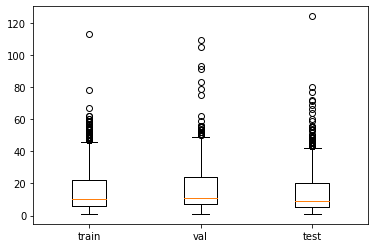

In [32]:
d = {"train" : [len(s) for s in train_data], "val" : [len(s) for s in val_data], "test" : [len(s) for s in test_data]}

fig, ax = plt.subplots()

ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
plt.show()

Except some sentences are 100-120 tokens length, we can use 64 tokens for a sentence.

In [33]:
MAX_SEQ_LENGTH = 64

In [34]:
def pad_sequence(sequence):
    padded_sequences = np.zeros((len(sequence),), dtype = int)
    
    current_len = len(sequence)

    if current_len <= MAX_SEQ_LENGTH:
        zeroes = list(np.zeros(MAX_SEQ_LENGTH - current_len))
        new = zeroes + sequence

    elif current_len > MAX_SEQ_LENGTH:
        new = sequence[0:MAX_SEQ_LENGTH]
        
    return new

In [35]:
vectorized_sample = vocabulary(next(iter(train_dataset))[0])
pad_sequence(vectorized_sample)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1003,
 18978,
 204,
 636,
 6,
 4082,
 215,
 6754,
 2]

Create a dataloader

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
def collate_batch(batch):
    sentences, labels = [], []
    
    for (sentence, label) in batch:
#         sentence_tensor = torch.tensor(pad_sequence(vocabulary(sentence)), dtype = torch.long)
        sentence_tensor = torch.tensor(vocabulary(sentence), dtype = torch.long)
        sentences.append(sentence_tensor)
        
#         label = torch.tensor(pad_sequence([label2idx[l] for l in label]), dtype = torch.long)
        label = torch.tensor([label2idx[l] for l in label], dtype = torch.long)
        labels.append(label)
    
    
    sentences = torch.cat(sentences)
    labels = torch.cat(labels)
    
    
    return sentences.to(device), labels.to(device)

# Model

In [38]:
class ConLLPOSTagging_RNN(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_dim):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.hidden_size = hidden_size
        
        self.embedding = torch.nn.Embedding(
            num_embeddings = self.vocab_size,
            embedding_dim = self.embedding_dim
        )
        
        self.rnn = torch.nn.RNN(
            input_size = self.embedding_dim,
            hidden_size = self.hidden_size
        )
        
        self.fc = torch.nn.Linear(
            in_features = self.hidden_size,
            out_features = self.output_dim
        )
    
    def forward(self, sentence):
        embedded = self.embedding(sentence)
        
        rnn_output, _ = self.rnn(embedded.view(len(sentence), 1, -1))
        tag_space = self.fc(rnn_output.view(len(sentence), -1))
        tag_scores = torch.nn.functional.log_softmax(tag_space, dim = 1)

        return tag_scores
        

Hyperparameters

In [39]:
batch_size = 64
epochs = 100
learning_rate = .0001

vocab_size = len(vocabulary)
embedding_dim = 64
hidden_size = 64
output_dim = len(unique_labels)

In [40]:
model = ConLLPOSTagging_RNN(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    hidden_size = hidden_size,
    output_dim = output_dim
).to(device)

In [41]:
# Loss function
loss_fn = torch.nn.NLLLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [42]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)

# Training

In [43]:
with torch.no_grad():
    inputs = next(iter(train_dataloader))
    tag_scores = model(inputs[0])
    print(tag_scores)

tensor([[-2.2008, -2.0379, -2.2866,  ..., -2.3651, -2.1653, -1.9848],
        [-2.1086, -3.0761, -2.4901,  ..., -2.0087, -2.0951, -2.0259],
        [-2.5898, -2.4517, -2.4575,  ..., -2.3190, -2.1135, -2.2404],
        ...,
        [-2.2251, -2.5519, -2.1989,  ..., -2.5777, -2.1116, -2.1239],
        [-1.9764, -1.9674, -2.1320,  ..., -2.8002, -2.0859, -2.8470],
        [-2.2770, -2.1053, -2.4054,  ..., -2.4642, -2.2925, -2.0116]],
       device='cuda:0')


In [44]:
import time

In [45]:
def train(loader):
    model.train()
    
    total_accuracy, total_count = 0, 0
    log_interval = 20

    start_time = time.time()
    
    for idx, (sentence, label) in enumerate(loader):
        optimizer.zero_grad()

        tag_scores = model(sentence)

        # Loss and backpropagation
        loss = loss_fn(tag_scores, label)
        loss.backward()
        optimizer.step()
        
        # Accuracy
        total_accuracy += (tag_scores.argmax(axis =1) == label).sum().item()
        total_count += label.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            elapsed_time = time.time() - start_time
    
            accuracy = total_accuracy / total_count
            
            print(f"Epoch {epoch + 1} / {epochs} | Batch: {idx} / {len(loader)} | Training loss: {loss} | Accuracy: {accuracy}")
            
            total_accuracy, total_count = 0, 0
            
            start_time = time.time()

In [46]:
def evaluate(loader):
    model.eval()
    
    total_loss, total_acc, total_count = 0, 0, 0
    
    with torch.no_grad():
        for idx, (sent, label) in enumerate(loader):
            tag_scores = model(sent)
            
            loss = loss_fn(tag_scores, label)
            
            total_loss += loss
            total_acc += (tag_scores.argmax(axis = 1) == label).sum().item()
            total_count += label.size(0)
    
    val_loss, val_acc = total_loss / total_count, total_acc / total_count
    
    return val_loss, val_acc

In [47]:
# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [48]:
patience = 10
verbose = True

early_stopping = EarlyStopping(patience = patience, verbose = verbose)

In [49]:
current_acc = 0.0
loss, acc = [], []

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    train(train_dataloader)
    
    val_loss, val_acc = evaluate(val_dataloader)
    
    loss.append(val_loss)
    acc.append(val_acc)
    
    print("-" * 50)
    print(f"End of epoch {epoch + 1} | time: {time.time() - epoch_start_time} | val_loss: {val_loss:.6f} | val_acc: {val_acc:.6f}")
    print("-" * 50)

    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 71 / 100 | Batch: 120 / 220 | Training loss: 0.20020709931850433 | Accuracy: 0.9471159148560715
Epoch 71 / 100 | Batch: 140 / 220 | Training loss: 0.16017919778823853 | Accuracy: 0.9495684724966206
Epoch 71 / 100 | Batch: 160 / 220 | Training loss: 0.18005718290805817 | Accuracy: 0.9467439592588579
Epoch 71 / 100 | Batch: 180 / 220 | Training loss: 0.1796077936887741 | Accuracy: 0.9464895237094996
Epoch 71 / 100 | Batch: 200 / 220 | Training loss: 0.2332601100206375 | Accuracy: 0.9442947455694891
--------------------------------------------------
End of epoch 71 | time: 5.258633375167847 | val_loss: 0.000328 | val_acc: 0.893637
--------------------------------------------------
Validation loss decreased (0.000328 --> 0.000328).  Saving model ...
Epoch 72 / 100 | Batch: 20 / 220 | Training loss: 0.16483566164970398 | Accuracy: 0.9509001636661211
Epoch 72 / 100 | Batch: 40 / 220 | Training loss: 0.16574309766292572 | Accuracy: 0.9500946864208533
Epoch 72 / 100 | Batch: 60 / 220 | T

In [50]:
import matplotlib.pyplot as plt

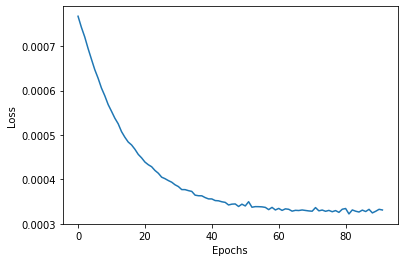

In [53]:
plt.plot([l.cpu() for l in loss])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

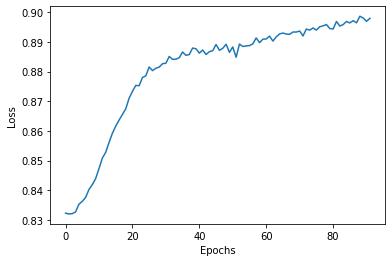

In [54]:
plt.plot(acc)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Prediction

In [55]:
best_checkpoint = ConLLPOSTagging_RNN(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    hidden_size = hidden_size,
    output_dim = output_dim
).to(device)

In [56]:
best_checkpoint.load_state_dict(torch.load("checkpoint.pt"))

<All keys matched successfully>

In [64]:
def predict(text):
    with torch.no_grad():
        text = torch.tensor(vocabulary(text)).to(device)
        output = best_checkpoint(text).to(device)
    
    
    return [x.item() for x in output.argmax(axis = 1)]

In [65]:
predicted = []
for text in test_data:
    predicted.append(predict(text))

A bizarre move: I'll fattern all sentences by appending all of them into 1 predicted and label vector.

In [72]:
y_pred, y_test = [], []

for s in predicted:
    for l in s:
        y_pred.append(l)

for s in test_labels:
    for l in s:
        y_test.append(label2idx[l])

In [75]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [86]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.6f} | Precision: {precision_score(y_test, y_pred, average = 'weighted'):.6f} | Recall: {recall_score(y_test, y_pred, average = 'weighted'):.6f} | F1 score: {f1_score(y_test, y_pred, average = 'weighted'):.6f}")


Accuracy: 0.858490 | Precision: 0.909933 | Recall: 0.858490 | F1 score: 0.877241


In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.35      0.47      1661
           1       0.27      0.57      0.37       216
           2       0.43      0.59      0.49       257
           3       0.39      0.44      0.41       835
           4       0.70      0.77      0.73      1668
           5       0.14      0.68      0.24       702
           6       0.60      0.85      0.70      1156
           7       0.74      0.54      0.62      1617
           8       0.98      0.91      0.94     38323

    accuracy                           0.86     46435
   macro avg       0.55      0.63      0.55     46435
weighted avg       0.91      0.86      0.88     46435



In [88]:
print(confusion_matrix(y_test, y_pred))

[[  589    15    17    62   294   410    30    74   170]
 [    0   123     4     6     0     7     9     2    65]
 [    0     9   151    33    12     6    22     0    24]
 [   12    28    73   371    20    41    56    23   211]
 [   60     8     7    15  1285   159    12    38    84]
 [   44    12     3     8    31   478     7    17   102]
 [    2    24     4    50     2    33   984    19    38]
 [   48     8     5    19    69   424    66   870   108]
 [  101   226    91   393   128  1781   457   133 35013]]


In [89]:
import seaborn as sns

In [85]:
for i in range(10):
    sample_predict = predict(test_data[i])
    for text, label_true, label_pred in zip(test_data[i], test_labels[i], sample_predict):
        print(text, label_true, idx2label[label_pred])
    
    print("-" * 50)

soccer O O
- O O
japan B-LOC B-LOC
get O O
lucky O O
win O O
, O O
china B-PER B-LOC
in O O
surprise O O
defeat O O
. O O
--------------------------------------------------
nadim B-PER B-MISC
ladki I-PER I-PER
--------------------------------------------------
al-ain B-LOC B-MISC
, O O
united B-LOC B-LOC
arab I-LOC I-ORG
emirates I-LOC I-ORG
1996-12-06 O I-PER
--------------------------------------------------
japan B-LOC B-LOC
began O O
the O O
defence O O
of O O
their O O
asian B-MISC O
cup I-MISC I-MISC
title O O
with O O
a O O
lucky O O
2-1 O O
win O O
against O O
syria B-LOC B-LOC
in O O
a O O
group O O
c O O
championship O O
match O O
on O O
friday O O
. O O
--------------------------------------------------
but O O
china B-LOC B-LOC
saw O O
their O O
luck O O
desert O O
them O O
in O O
the O O
second O O
match O O
of O O
the O O
group O O
, O O
crashing O O
to O O
a O O
surprise O O
2-0 O O
defeat O O
to O O
newcomers O O
uzbekistan B-LOC B-MISC
. O O
---------------------------